In [ ]:
# Handwritten Digits Generator With a GAN

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print (device)

cuda


# Preparing the Training Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

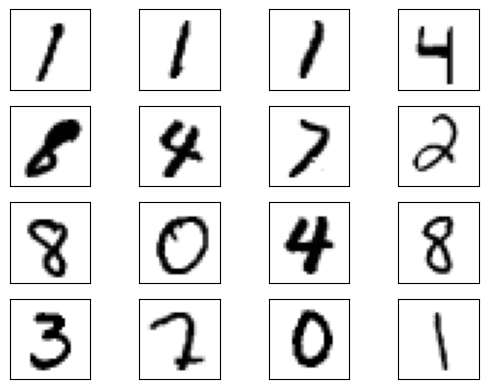

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Implementing the Discriminator and the Generator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

# Training the Models

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5889771580696106
Epoch: 0 Loss G.: 0.4736277759075165
Epoch: 1 Loss D.: 0.028150778263807297
Epoch: 1 Loss G.: 5.334431171417236
Epoch: 2 Loss D.: 0.0006720678065903485
Epoch: 2 Loss G.: 12.967259407043457
Epoch: 3 Loss D.: 0.018401801586151123
Epoch: 3 Loss G.: 6.738242149353027
Epoch: 4 Loss D.: 0.013765417039394379
Epoch: 4 Loss G.: 5.320888996124268
Epoch: 5 Loss D.: 0.1826200932264328
Epoch: 5 Loss G.: 4.3525590896606445
Epoch: 6 Loss D.: 0.030330706387758255
Epoch: 6 Loss G.: 5.326847076416016
Epoch: 7 Loss D.: 0.09873221814632416
Epoch: 7 Loss G.: 4.248191833496094
Epoch: 8 Loss D.: 0.0036748142447322607
Epoch: 8 Loss G.: 9.374857902526855
Epoch: 9 Loss D.: 1.377788238926818e-15
Epoch: 9 Loss G.: 60.057830810546875
Epoch: 10 Loss D.: 0.0
Epoch: 10 Loss G.: 100.0
Epoch: 11 Loss D.: 9.821359019627348e-39
Epoch: 11 Loss G.: 100.0
Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 100.0
Epoch: 13 Loss D.: 0.0
Epoch: 13 Loss G.: 100.0
Epoch: 14 Loss D.: 0.0
Epoch: 14 Loss 

# Checking the Samples Generated by the GAN

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

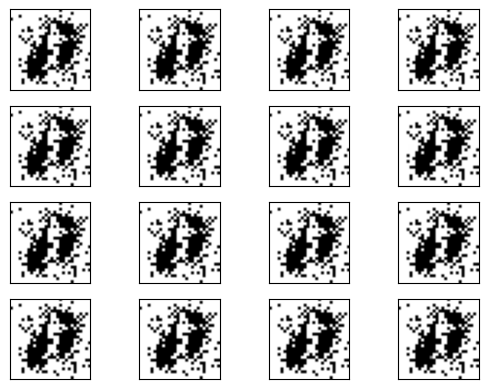

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])